In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_conv_3_DO(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same', 
                      activation='relu', input_shape=input_shape)) 
#     model.add(BatchNormalization())
#     model.add(MaxPooling1D(pool_size=3, strides=3))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same', 
                          activation='relu'))
#         model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_conv_3_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         256       
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 16,384,272
Trainable params: 16,384,272
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (ty

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 5333, 64)          12352     
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 1777, 64)          0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 1777, 64)          12352     
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 592, 64)           0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4958 - acc: 0.2085
Epoch 00001: val_loss improved from inf to 2.39163, saving model to model/checkpoint/1D_CNN_1_conv_custom_conv_3_DO_checkpoint/001-2.3916.hdf5
36805/36805 [==============================] - 29s 781us/sample - loss: 2.4958 - acc: 0.2085 - val_loss: 2.3916 - val_acc: 0.2262
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.1419 - acc: 0.3522
Epoch 00002: val_loss improved from 2.39163 to 2.32499, saving model to model/checkpoint/1D_CNN_1_conv_custom_conv_3_DO_checkpoint/002-2.3250.hdf5
36805/36805 [==============================] - 27s 730us/sample - loss: 2.1420 - acc: 0.3522 - val_loss: 2.3250 - val_acc: 0.2630
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8910 - acc: 0.4411
Epoch 00003: val_loss did not improve from 2.32499
36805/36805 [=

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2331 - acc: 0.9545
Epoch 00029: val_loss did not improve from 2.32499
36805/36805 [==============================] - 26s 704us/sample - loss: 0.2331 - acc: 0.9545 - val_loss: 4.0689 - val_acc: 0.2527
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2135 - acc: 0.9598
Epoch 00030: val_loss did not improve from 2.32499
36805/36805 [==============================] - 26s 703us/sample - loss: 0.2135 - acc: 0.9598 - val_loss: 4.1307 - val_acc: 0.2642
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2027 - acc: 0.9621
Epoch 00031: val_loss did not improve from 2.32499
36805/36805 [==============================] - 26s 707us/sample - loss: 0.2028 - acc: 0.9621 - val_loss: 4.2280 - val_acc: 0.2548
Epoch 32/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1859 - acc: 0.9676
Epoch 00032: val_loss did not improve from 2.32499
36805/36805 [=====

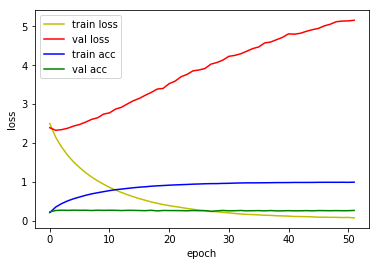

4815/4815 [==============================] - 2s 329us/sample - loss: 2.3283 - acc: 0.2569
Loss: 2.328297340337609 Accuracy: 0.2569055

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3579 - acc: 0.2581
Epoch 00001: val_loss improved from inf to 2.13599, saving model to model/checkpoint/1D_CNN_2_conv_custom_conv_3_DO_checkpoint/001-2.1360.hdf5
36805/36805 [==============================] - 39s 1ms/sample - loss: 2.3579 - acc: 0.2580 - val_loss: 2.1360 - val_acc: 0.3403
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9674 - acc: 0.4044
Epoch 00002: val_loss improved from 2.13599 to 1.99470, saving model to model/checkpoint/1D_CNN_2_conv_custom_conv_3_DO_checkpoint/002-1.9947.hdf5
36805/36805 [==============================] - 38s 1ms/sample - loss: 1.9674 - acc: 0.4044 - val_loss: 1.9947 - val_acc: 0.3927
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7

36800/36805 [============================>.] - ETA: 0s - loss: 0.1377 - acc: 0.9696
Epoch 00029: val_loss did not improve from 1.92433
36805/36805 [==============================] - 38s 1ms/sample - loss: 0.1377 - acc: 0.9697 - val_loss: 3.5233 - val_acc: 0.4027
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1262 - acc: 0.9719
Epoch 00030: val_loss did not improve from 1.92433
36805/36805 [==============================] - 38s 1ms/sample - loss: 0.1262 - acc: 0.9719 - val_loss: 3.5844 - val_acc: 0.4030
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1238 - acc: 0.9729
Epoch 00031: val_loss did not improve from 1.92433
36805/36805 [==============================] - 38s 1ms/sample - loss: 0.1238 - acc: 0.9729 - val_loss: 3.6415 - val_acc: 0.4011
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1118 - acc: 0.9756
Epoch 00032: val_loss did not improve from 1.92433
36805/36805 [========================

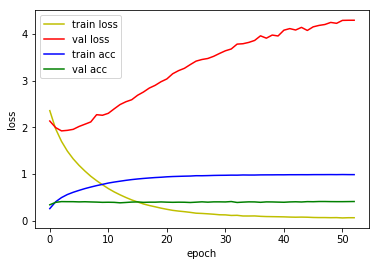

4815/4815 [==============================] - 2s 480us/sample - loss: 1.9484 - acc: 0.3961
Loss: 1.9483548640214519 Accuracy: 0.396054

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2864 - acc: 0.2793
Epoch 00001: val_loss improved from inf to 1.96475, saving model to model/checkpoint/1D_CNN_3_conv_custom_conv_3_DO_checkpoint/001-1.9647.hdf5
36805/36805 [==============================] - 43s 1ms/sample - loss: 2.2864 - acc: 0.2793 - val_loss: 1.9647 - val_acc: 0.4118
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8070 - acc: 0.4499
Epoch 00002: val_loss improved from 1.96475 to 1.73310, saving model to model/checkpoint/1D_CNN_3_conv_custom_conv_3_DO_checkpoint/002-1.7331.hdf5
36805/36805 [==============================] - 42s 1ms/sample - loss: 1.8069 - acc: 0.4499 - val_loss: 1.7331 - val_acc: 0.4715
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2985 - acc: 0.9067
Epoch 00028: val_loss did not improve from 1.61623
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.2985 - acc: 0.9067 - val_loss: 2.0463 - val_acc: 0.5476
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2812 - acc: 0.9120
Epoch 00029: val_loss did not improve from 1.61623
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.2812 - acc: 0.9121 - val_loss: 2.0578 - val_acc: 0.5560
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2725 - acc: 0.9145
Epoch 00030: val_loss did not improve from 1.61623
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.2725 - acc: 0.9145 - val_loss: 2.1180 - val_acc: 0.5504
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2536 - acc: 0.9224
Epoch 00031: val_loss did not improve from 1.61623
36805/36805 [===========


1D_CNN_3_conv_custom_conv_3_DO Model


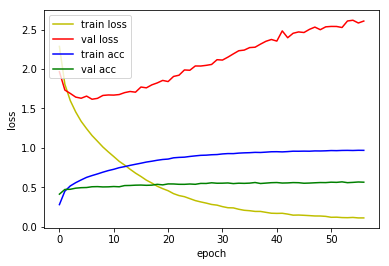

4815/4815 [==============================] - 3s 525us/sample - loss: 1.6956 - acc: 0.4795
Loss: 1.6955603861734503 Accuracy: 0.4795431

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2507 - acc: 0.2878
Epoch 00001: val_loss improved from inf to 1.85787, saving model to model/checkpoint/1D_CNN_4_conv_custom_conv_3_DO_checkpoint/001-1.8579.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 2.2507 - acc: 0.2878 - val_loss: 1.8579 - val_acc: 0.4370
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6831 - acc: 0.4723
Epoch 00002: val_loss improved from 1.85787 to 1.54766, saving model to model/checkpoint/1D_CNN_4_conv_custom_conv_3_DO_checkpoint/002-1.5477.hdf5
36805/36805 [==============================] - 43s 1ms/sample - loss: 1.6831 - acc: 0.4723 - val_loss: 1.5477 - val_acc: 0.5204
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3736 - acc: 0.8817
Epoch 00026: val_loss did not improve from 1.13483
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.3736 - acc: 0.8817 - val_loss: 1.2432 - val_acc: 0.6678
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3650 - acc: 0.8828
Epoch 00027: val_loss did not improve from 1.13483
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.3651 - acc: 0.8828 - val_loss: 1.2474 - val_acc: 0.6746
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3479 - acc: 0.8873
Epoch 00028: val_loss did not improve from 1.13483
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.3479 - acc: 0.8873 - val_loss: 1.2573 - val_acc: 0.6737
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3262 - acc: 0.8942
Epoch 00029: val_loss did not improve from 1.13483
36805/36805 [===========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1459 - acc: 0.9537
Epoch 00056: val_loss did not improve from 1.13483
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.1460 - acc: 0.9537 - val_loss: 1.4637 - val_acc: 0.7079
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1476 - acc: 0.9536
Epoch 00057: val_loss did not improve from 1.13483
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.1476 - acc: 0.9536 - val_loss: 1.4548 - val_acc: 0.7000
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1382 - acc: 0.9565
Epoch 00058: val_loss did not improve from 1.13483
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.1382 - acc: 0.9566 - val_loss: 1.5130 - val_acc: 0.7032
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1324 - acc: 0.9580
Epoch 00059: val_loss did not improve from 1.13483
36805/36805 [===========

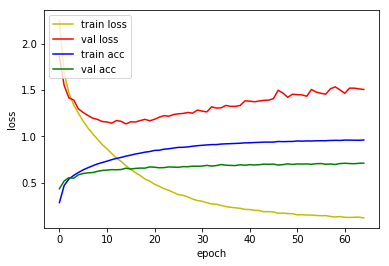

4815/4815 [==============================] - 2s 516us/sample - loss: 1.2561 - acc: 0.6278
Loss: 1.2561477027082988 Accuracy: 0.6278297

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2041 - acc: 0.2888
Epoch 00001: val_loss improved from inf to 1.76188, saving model to model/checkpoint/1D_CNN_5_conv_custom_conv_3_DO_checkpoint/001-1.7619.hdf5
36805/36805 [==============================] - 47s 1ms/sample - loss: 2.2040 - acc: 0.2888 - val_loss: 1.7619 - val_acc: 0.4337
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5996 - acc: 0.4917
Epoch 00002: val_loss improved from 1.76188 to 1.42912, saving model to model/checkpoint/1D_CNN_5_conv_custom_conv_3_DO_checkpoint/002-1.4291.hdf5
36805/36805 [==============================] - 44s 1ms/sample - loss: 1.5996 - acc: 0.4916 - val_loss: 1.4291 - val_acc: 0.5637
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1451 - acc: 0.9538
Epoch 00055: val_loss did not improve from 0.90783
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.1451 - acc: 0.9538 - val_loss: 1.1143 - val_acc: 0.7619
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1438 - acc: 0.9534
Epoch 00056: val_loss did not improve from 0.90783
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.1438 - acc: 0.9534 - val_loss: 1.1646 - val_acc: 0.7612
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1436 - acc: 0.9527
Epoch 00057: val_loss did not improve from 0.90783
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.1436 - acc: 0.9527 - val_loss: 1.1362 - val_acc: 0.7661
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1392 - acc: 0.9545
Epoch 00058: val_loss did not improve from 0.90783
36805/36805 [===========

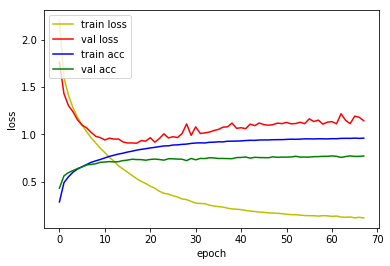

4815/4815 [==============================] - 3s 545us/sample - loss: 1.0106 - acc: 0.6941
Loss: 1.0106030552434278 Accuracy: 0.694081

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3496 - acc: 0.2289
Epoch 00001: val_loss improved from inf to 1.77711, saving model to model/checkpoint/1D_CNN_6_conv_custom_conv_3_DO_checkpoint/001-1.7771.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 2.3495 - acc: 0.2289 - val_loss: 1.7771 - val_acc: 0.4300
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6689 - acc: 0.4556
Epoch 00002: val_loss improved from 1.77711 to 1.46854, saving model to model/checkpoint/1D_CNN_6_conv_custom_conv_3_DO_checkpoint/002-1.4685.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 1.6688 - acc: 0.4556 - val_loss: 1.4685 - val_acc: 0.5416
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5017 - acc: 0.8472
Epoch 00024: val_loss improved from 0.61592 to 0.59190, saving model to model/checkpoint/1D_CNN_6_conv_custom_conv_3_DO_checkpoint/024-0.5919.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.5018 - acc: 0.8472 - val_loss: 0.5919 - val_acc: 0.8362
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4852 - acc: 0.8532
Epoch 00025: val_loss improved from 0.59190 to 0.56742, saving model to model/checkpoint/1D_CNN_6_conv_custom_conv_3_DO_checkpoint/025-0.5674.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.4852 - acc: 0.8532 - val_loss: 0.5674 - val_acc: 0.8404
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4674 - acc: 0.8592
Epoch 00026: val_loss did not improve from 0.56742
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.4675 - acc: 0.8591 - val_loss: 0.640

Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2372 - acc: 0.9244
Epoch 00051: val_loss did not improve from 0.51618
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.2372 - acc: 0.9244 - val_loss: 0.5493 - val_acc: 0.8614
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2419 - acc: 0.9235
Epoch 00052: val_loss did not improve from 0.51618
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.2419 - acc: 0.9235 - val_loss: 0.5784 - val_acc: 0.8544
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2402 - acc: 0.9224
Epoch 00053: val_loss did not improve from 0.51618
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.2402 - acc: 0.9224 - val_loss: 0.5673 - val_acc: 0.8605
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2276 - acc: 0.9260
Epoch 00054: val_loss did not improve from 0.51618
36805/36805 [===========

Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1580 - acc: 0.9473
Epoch 00081: val_loss did not improve from 0.51618
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1582 - acc: 0.9473 - val_loss: 0.5936 - val_acc: 0.8616
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1498 - acc: 0.9492
Epoch 00082: val_loss did not improve from 0.51618
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1498 - acc: 0.9492 - val_loss: 0.5865 - val_acc: 0.8663
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1448 - acc: 0.9521
Epoch 00083: val_loss did not improve from 0.51618
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1448 - acc: 0.9521 - val_loss: 0.5384 - val_acc: 0.8775
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1409 - acc: 0.9532
Epoch 00084: val_loss did not improve from 0.51618
36805/36805 [===========

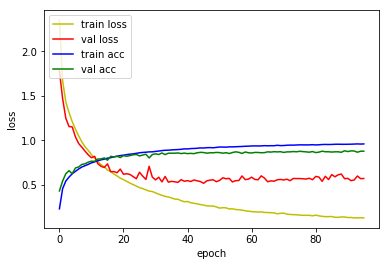

4815/4815 [==============================] - 3s 565us/sample - loss: 0.6294 - acc: 0.8299
Loss: 0.6293874348435446 Accuracy: 0.8299065

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4603 - acc: 0.1934
Epoch 00001: val_loss improved from inf to 1.85230, saving model to model/checkpoint/1D_CNN_7_conv_custom_conv_3_DO_checkpoint/001-1.8523.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 2.4601 - acc: 0.1934 - val_loss: 1.8523 - val_acc: 0.4232
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7148 - acc: 0.4364
Epoch 00002: val_loss improved from 1.85230 to 1.40246, saving model to model/checkpoint/1D_CNN_7_conv_custom_conv_3_DO_checkpoint/002-1.4025.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 1.7149 - acc: 0.4363 - val_loss: 1.4025 - val_acc: 0.5642
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.

Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2384 - acc: 0.9231
Epoch 00049: val_loss improved from 0.27943 to 0.27730, saving model to model/checkpoint/1D_CNN_7_conv_custom_conv_3_DO_checkpoint/049-0.2773.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.2384 - acc: 0.9231 - val_loss: 0.2773 - val_acc: 0.9224
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2377 - acc: 0.9251
Epoch 00050: val_loss improved from 0.27730 to 0.27613, saving model to model/checkpoint/1D_CNN_7_conv_custom_conv_3_DO_checkpoint/050-0.2761.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.2377 - acc: 0.9251 - val_loss: 0.2761 - val_acc: 0.9278
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2347 - acc: 0.9260
Epoch 00051: val_loss did not improve from 0.27613
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.2347 - acc: 0.9260 - val_loss: 0.281

Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1599 - acc: 0.9462
Epoch 00077: val_loss did not improve from 0.25130
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1599 - acc: 0.9462 - val_loss: 0.2630 - val_acc: 0.9355
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1559 - acc: 0.9495
Epoch 00078: val_loss did not improve from 0.25130
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1560 - acc: 0.9494 - val_loss: 0.2711 - val_acc: 0.9343
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1606 - acc: 0.9462
Epoch 00079: val_loss did not improve from 0.25130
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1606 - acc: 0.9461 - val_loss: 0.2726 - val_acc: 0.9306
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1554 - acc: 0.9485
Epoch 00080: val_loss did not improve from 0.25130
36805/36805 [===========

Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1168 - acc: 0.9609
Epoch 00107: val_loss did not improve from 0.25130
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1168 - acc: 0.9609 - val_loss: 0.2827 - val_acc: 0.9352
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1175 - acc: 0.9598
Epoch 00108: val_loss did not improve from 0.25130
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1175 - acc: 0.9598 - val_loss: 0.2688 - val_acc: 0.9425
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1122 - acc: 0.9630
Epoch 00109: val_loss did not improve from 0.25130
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1122 - acc: 0.9630 - val_loss: 0.2933 - val_acc: 0.9336
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1145 - acc: 0.9618
Epoch 00110: val_loss did not improve from 0.25130
36805/36805 [=======

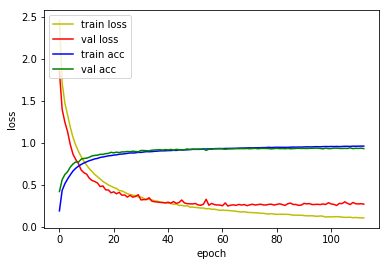

4815/4815 [==============================] - 3s 604us/sample - loss: 0.2910 - acc: 0.9153
Loss: 0.2909540087882108 Accuracy: 0.9152648

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4746 - acc: 0.1887
Epoch 00001: val_loss improved from inf to 1.71182, saving model to model/checkpoint/1D_CNN_8_conv_custom_conv_3_DO_checkpoint/001-1.7118.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 2.4746 - acc: 0.1887 - val_loss: 1.7118 - val_acc: 0.4836
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6293 - acc: 0.4653
Epoch 00002: val_loss improved from 1.71182 to 1.19726, saving model to model/checkpoint/1D_CNN_8_conv_custom_conv_3_DO_checkpoint/002-1.1973.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 1.6294 - acc: 0.4653 - val_loss: 1.1973 - val_acc: 0.6285
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3415 - acc: 0.8927
Epoch 00024: val_loss improved from 0.25794 to 0.23135, saving model to model/checkpoint/1D_CNN_8_conv_custom_conv_3_DO_checkpoint/024-0.2314.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.3414 - acc: 0.8927 - val_loss: 0.2314 - val_acc: 0.9327
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3210 - acc: 0.8974
Epoch 00025: val_loss improved from 0.23135 to 0.22763, saving model to model/checkpoint/1D_CNN_8_conv_custom_conv_3_DO_checkpoint/025-0.2276.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.3210 - acc: 0.8974 - val_loss: 0.2276 - val_acc: 0.9315
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3131 - acc: 0.8991
Epoch 00026: val_loss improved from 0.22763 to 0.21640, saving model to model/checkpoint/1D_CNN_8_conv_custom_conv_3_DO_checkpoint/026-0.2164.hdf5
36805/36805 

Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1926 - acc: 0.9367
Epoch 00050: val_loss improved from 0.17605 to 0.17587, saving model to model/checkpoint/1D_CNN_8_conv_custom_conv_3_DO_checkpoint/050-0.1759.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1926 - acc: 0.9367 - val_loss: 0.1759 - val_acc: 0.9462
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1875 - acc: 0.9378
Epoch 00051: val_loss did not improve from 0.17587
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1874 - acc: 0.9378 - val_loss: 0.1847 - val_acc: 0.9462
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1851 - acc: 0.9395
Epoch 00052: val_loss did not improve from 0.17587
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1851 - acc: 0.9395 - val_loss: 0.1934 - val_acc: 0.9415
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 

Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1229 - acc: 0.9590
Epoch 00079: val_loss did not improve from 0.15928
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1229 - acc: 0.9590 - val_loss: 0.1721 - val_acc: 0.9515
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1188 - acc: 0.9599
Epoch 00080: val_loss did not improve from 0.15928
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1188 - acc: 0.9599 - val_loss: 0.1791 - val_acc: 0.9518
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1138 - acc: 0.9620
Epoch 00081: val_loss did not improve from 0.15928
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1138 - acc: 0.9620 - val_loss: 0.1662 - val_acc: 0.9532
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1188 - acc: 0.9604
Epoch 00082: val_loss did not improve from 0.15928
36805/36805 [===========

Epoch 138/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0586 - acc: 0.9797
Epoch 00138: val_loss did not improve from 0.15633
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0586 - acc: 0.9797 - val_loss: 0.1890 - val_acc: 0.9543
Epoch 139/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0612 - acc: 0.9795
Epoch 00139: val_loss did not improve from 0.15633
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0612 - acc: 0.9795 - val_loss: 0.1957 - val_acc: 0.9560
Epoch 140/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0591 - acc: 0.9804
Epoch 00140: val_loss did not improve from 0.15633
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0591 - acc: 0.9804 - val_loss: 0.1899 - val_acc: 0.9574
Epoch 141/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0601 - acc: 0.9799
Epoch 00141: val_loss did not improve from 0.15633
36805/36805 [=======

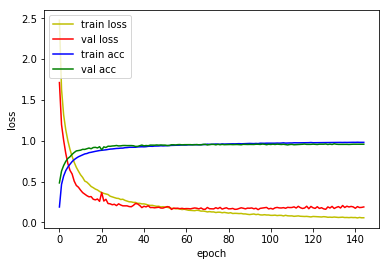

4815/4815 [==============================] - 3s 545us/sample - loss: 0.1899 - acc: 0.9443
Loss: 0.18985166766933192 Accuracy: 0.9443406

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2601 - acc: 0.2634
Epoch 00001: val_loss improved from inf to 1.43353, saving model to model/checkpoint/1D_CNN_9_conv_custom_conv_3_DO_checkpoint/001-1.4335.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 2.2600 - acc: 0.2635 - val_loss: 1.4335 - val_acc: 0.5563
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3645 - acc: 0.5537
Epoch 00002: val_loss improved from 1.43353 to 0.93191, saving model to model/checkpoint/1D_CNN_9_conv_custom_conv_3_DO_checkpoint/002-0.9319.hdf5
36805/36805 [==============================] - 47s 1ms/sample - loss: 1.3646 - acc: 0.5536 - val_loss: 0.9319 - val_acc: 0.7205
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2146 - acc: 0.9305
Epoch 00024: val_loss improved from 0.19252 to 0.19247, saving model to model/checkpoint/1D_CNN_9_conv_custom_conv_3_DO_checkpoint/024-0.1925.hdf5
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.2147 - acc: 0.9305 - val_loss: 0.1925 - val_acc: 0.9404
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2084 - acc: 0.9319
Epoch 00025: val_loss improved from 0.19247 to 0.17917, saving model to model/checkpoint/1D_CNN_9_conv_custom_conv_3_DO_checkpoint/025-0.1792.hdf5
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.2083 - acc: 0.9319 - val_loss: 0.1792 - val_acc: 0.9446
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1980 - acc: 0.9361
Epoch 00026: val_loss improved from 0.17917 to 0.17511, saving model to model/checkpoint/1D_CNN_9_conv_custom_conv_3_DO_checkpoint/026-0.1751.hdf5
36805/36805 

Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1010 - acc: 0.9656
Epoch 00050: val_loss did not improve from 0.15192
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1010 - acc: 0.9656 - val_loss: 0.1719 - val_acc: 0.9536
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0944 - acc: 0.9677
Epoch 00051: val_loss did not improve from 0.15192
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0944 - acc: 0.9677 - val_loss: 0.1719 - val_acc: 0.9504
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0985 - acc: 0.9662
Epoch 00052: val_loss did not improve from 0.15192
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0985 - acc: 0.9662 - val_loss: 0.1682 - val_acc: 0.9539
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0884 - acc: 0.9691
Epoch 00053: val_loss did not improve from 0.15192
36805/36805 [===========

Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0518 - acc: 0.9818
Epoch 00080: val_loss did not improve from 0.15192
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0518 - acc: 0.9819 - val_loss: 0.1831 - val_acc: 0.9583
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0518 - acc: 0.9830
Epoch 00081: val_loss did not improve from 0.15192
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0517 - acc: 0.9830 - val_loss: 0.1747 - val_acc: 0.9567
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0489 - acc: 0.9831
Epoch 00082: val_loss did not improve from 0.15192
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.0489 - acc: 0.9831 - val_loss: 0.1931 - val_acc: 0.9560
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0488 - acc: 0.9830
Epoch 00083: val_loss did not improve from 0.15192
36805/36805 [===========

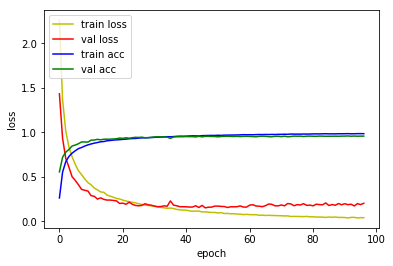

4815/4815 [==============================] - 3s 641us/sample - loss: 0.1995 - acc: 0.9402
Loss: 0.19947422533948844 Accuracy: 0.9401869



In [10]:
for i in range(1, 10):
    model_name = '1D_CNN_{}_conv_custom_conv_3_DO'.format(i)
    model = build_1d_cnn_custom_conv_3_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
for i in range(1, 10):
    model_name = '1D_CNN_{}_conv_custom_conv_3_DO'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_1_conv_custom_conv_3_DO Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024000)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 16,384,272
Trainable params: 16,384,272
Non-trainable params: 0
_________________________________________________________________
4815/4815 [==============================] - 2s 390us/sample - loss: 2.3283 - acc: 0.2569
Loss: 2.328297340337609 Accuracy: 0.2569055

1D_CNN_2_conv_custom_conv_3_DO Model
____________________________________________________

4815/4815 [==============================] - 3s 646us/sample - loss: 0.6294 - acc: 0.8299
Loss: 0.6293874348435446 Accuracy: 0.8299065

1D_CNN_7_conv_custom_conv_3_DO Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_66 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_67 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_51 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 5333, 64)          12352     
_________________________________________________________________
max_pooling1d_52 (MaxPooling (None, 1777, 64)          0         
_________________________________________________________________
conv1d_69 (Conv1D)           (None,

4815/4815 [==============================] - 3s 707us/sample - loss: 0.1995 - acc: 0.9402
Loss: 0.19947422533948844 Accuracy: 0.9401869


In [12]:
def build_1d_cnn_custom_conv_3_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, 
                      padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    model.add(BatchNormalization())
#     model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [13]:
for i in range(1, 10):
    model = build_1d_cnn_custom_conv_3_BN(conv_num=i)
    model.summary()
    del model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
flatten_18 (Flatten)         (None, 1024000)           0         
_________________________________________________________________
dense_18 (Dense)             (None, 16)                16384016  
Total params: 16,384,528
Trainable params: 16,384,400
Non-trainable params: 128
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_91 (Conv1D)           (None, 16000, 64)         256       
______________________________________________________________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_105 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_15 (B (None, 16000, 64)         256       
_________________________________________________________________
conv1d_106 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_16 (B (None, 16000, 64)         256       
_________________________________________________________________
max_pooling1d_82 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_107 (Conv1D)          (None, 5333, 64)          12352     
_________________________________________________________________
batch_normalization_v1_17 (B (None, 5333, 64)          256       
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_126 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_36 (B (None, 16000, 64)         256       
_________________________________________________________________
conv1d_127 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_37 (B (None, 16000, 64)         256       
_________________________________________________________________
max_pooling1d_100 (MaxPoolin (None, 5333, 64)          0         
_________________________________________________________________
conv1d_128 (Conv1D)          (None, 5333, 64)          12352     
_________________________________________________________________
batch_normalization_v1_38 (B (None, 5333, 64)          256       
__________

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.7725 - acc: 0.2047
Epoch 00001: val_loss improved from inf to 2.47565, saving model to model/checkpoint/1D_CNN_1_conv_custom_conv_3_BN_checkpoint/001-2.4756.hdf5
36805/36805 [==============================] - 42s 1ms/sample - loss: 3.7723 - acc: 0.2047 - val_loss: 2.4756 - val_acc: 0.2103
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5345 - acc: 0.5503
Epoch 00002: val_loss did not improve from 2.47565
36805/36805 [==============================] - 33s 910us/sample - loss: 1.5346 - acc: 0.5503 - val_loss: 2.9545 - val_acc: 0.2106
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0103 - acc: 0.7143
Epoch 00003: val_loss did not improve from 2.47565
36805/36805 [==============================] - 33s 910us/sample - loss: 1.0103 - acc: 0.7143 - val_loss: 2.8414 - val_acc: 0.2693
Epoch 4/500
36800/36805 [=====

36800/36805 [============================>.] - ETA: 0s - loss: 0.0243 - acc: 0.9985
Epoch 00030: val_loss did not improve from 2.47565
36805/36805 [==============================] - 34s 911us/sample - loss: 0.0243 - acc: 0.9985 - val_loss: 7.5179 - val_acc: 0.2292
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0242 - acc: 0.9985
Epoch 00031: val_loss did not improve from 2.47565
36805/36805 [==============================] - 33s 910us/sample - loss: 0.0242 - acc: 0.9985 - val_loss: 7.6131 - val_acc: 0.2283
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0241 - acc: 0.9985
Epoch 00032: val_loss did not improve from 2.47565
36805/36805 [==============================] - 34s 911us/sample - loss: 0.0241 - acc: 0.9985 - val_loss: 7.6673 - val_acc: 0.2299
Epoch 33/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0240 - acc: 0.9985
Epoch 00033: val_loss did not improve from 2.47565
36805/36805 [==================

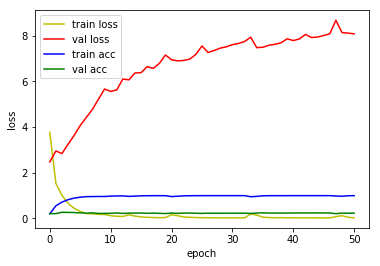

4815/4815 [==============================] - 3s 594us/sample - loss: 2.4927 - acc: 0.2008
Loss: 2.4927360383644777 Accuracy: 0.20083074

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 5.1695 - acc: 0.3007
Epoch 00001: val_loss improved from inf to 8.12736, saving model to model/checkpoint/1D_CNN_2_conv_custom_conv_3_BN_checkpoint/001-8.1274.hdf5
36805/36805 [==============================] - 75s 2ms/sample - loss: 5.1698 - acc: 0.3006 - val_loss: 8.1274 - val_acc: 0.2187
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2218 - acc: 0.6224
Epoch 00002: val_loss improved from 8.12736 to 4.54722, saving model to model/checkpoint/1D_CNN_2_conv_custom_conv_3_BN_checkpoint/002-4.5472.hdf5
36805/36805 [==============================] - 64s 2ms/sample - loss: 2.2221 - acc: 0.6224 - val_loss: 4.5472 - val_acc: 0.3576
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1

36800/36805 [============================>.] - ETA: 0s - loss: 0.2019 - acc: 0.9811
Epoch 00029: val_loss did not improve from 4.11365
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.2019 - acc: 0.9811 - val_loss: 6.5643 - val_acc: 0.3857
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2077 - acc: 0.9805
Epoch 00030: val_loss did not improve from 4.11365
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.2081 - acc: 0.9805 - val_loss: 6.7342 - val_acc: 0.3962
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1977 - acc: 0.9821
Epoch 00031: val_loss did not improve from 4.11365
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.1976 - acc: 0.9821 - val_loss: 7.0121 - val_acc: 0.3711
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1964 - acc: 0.9824
Epoch 00032: val_loss did not improve from 4.11365
36805/36805 [========================

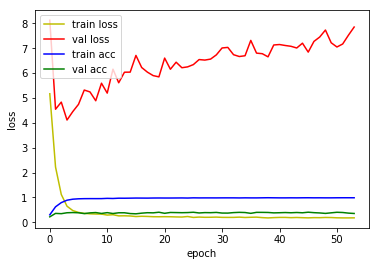

4815/4815 [==============================] - 4s 857us/sample - loss: 4.3744 - acc: 0.3551
Loss: 4.374357089966629 Accuracy: 0.35514018

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.8685 - acc: 0.3763
Epoch 00001: val_loss improved from inf to 4.91537, saving model to model/checkpoint/1D_CNN_3_conv_custom_conv_3_BN_checkpoint/001-4.9154.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 2.8684 - acc: 0.3763 - val_loss: 4.9154 - val_acc: 0.2225
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3629 - acc: 0.6521
Epoch 00002: val_loss improved from 4.91537 to 2.41027, saving model to model/checkpoint/1D_CNN_3_conv_custom_conv_3_BN_checkpoint/002-2.4103.hdf5
36805/36805 [==============================] - 74s 2ms/sample - loss: 1.3630 - acc: 0.6521 - val_loss: 2.4103 - val_acc: 0.4726
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.

Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0747 - acc: 0.9877
Epoch 00030: val_loss did not improve from 2.41027
36805/36805 [==============================] - 74s 2ms/sample - loss: 0.0752 - acc: 0.9877 - val_loss: 5.1737 - val_acc: 0.4733
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0928 - acc: 0.9833
Epoch 00031: val_loss did not improve from 2.41027
36805/36805 [==============================] - 74s 2ms/sample - loss: 0.0928 - acc: 0.9833 - val_loss: 5.3714 - val_acc: 0.4482
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0576 - acc: 0.9923
Epoch 00032: val_loss did not improve from 2.41027
36805/36805 [==============================] - 74s 2ms/sample - loss: 0.0576 - acc: 0.9923 - val_loss: 4.6268 - val_acc: 0.5155
Epoch 33/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0548 - acc: 0.9927
Epoch 00033: val_loss did not improve from 2.41027
36805/36805 [===========

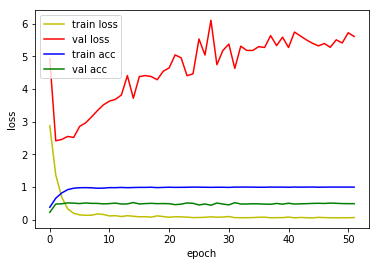

4815/4815 [==============================] - 5s 944us/sample - loss: 2.6020 - acc: 0.4347
Loss: 2.602035830746311 Accuracy: 0.4346833

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0548 - acc: 0.4310
Epoch 00001: val_loss improved from inf to 3.16351, saving model to model/checkpoint/1D_CNN_4_conv_custom_conv_3_BN_checkpoint/001-3.1635.hdf5
36805/36805 [==============================] - 94s 3ms/sample - loss: 2.0546 - acc: 0.4310 - val_loss: 3.1635 - val_acc: 0.2628
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2228 - acc: 0.6379
Epoch 00002: val_loss improved from 3.16351 to 1.51818, saving model to model/checkpoint/1D_CNN_4_conv_custom_conv_3_BN_checkpoint/002-1.5182.hdf5
36805/36805 [==============================] - 78s 2ms/sample - loss: 1.2230 - acc: 0.6379 - val_loss: 1.5182 - val_acc: 0.5819
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0258 - acc: 0.9957
Epoch 00029: val_loss did not improve from 1.42727
36805/36805 [==============================] - 78s 2ms/sample - loss: 0.0258 - acc: 0.9957 - val_loss: 2.6131 - val_acc: 0.6059
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0261 - acc: 0.9961
Epoch 00030: val_loss did not improve from 1.42727
36805/36805 [==============================] - 77s 2ms/sample - loss: 0.0261 - acc: 0.9961 - val_loss: 2.4984 - val_acc: 0.6229
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0218 - acc: 0.9971
Epoch 00031: val_loss did not improve from 1.42727
36805/36805 [==============================] - 77s 2ms/sample - loss: 0.0218 - acc: 0.9971 - val_loss: 2.6059 - val_acc: 0.6154
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0296 - acc: 0.9950
Epoch 00032: val_loss did not improve from 1.42727
36805/36805 [===========

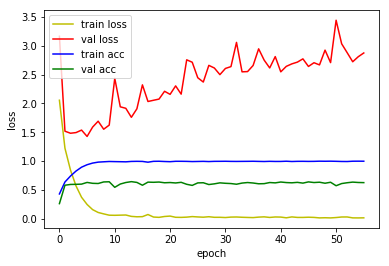

4815/4815 [==============================] - 5s 990us/sample - loss: 1.6179 - acc: 0.5850
Loss: 1.6179011679884059 Accuracy: 0.5850467

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8382 - acc: 0.4686
Epoch 00001: val_loss improved from inf to 2.47893, saving model to model/checkpoint/1D_CNN_5_conv_custom_conv_3_BN_checkpoint/001-2.4789.hdf5
36805/36805 [==============================] - 101s 3ms/sample - loss: 1.8384 - acc: 0.4686 - val_loss: 2.4789 - val_acc: 0.3240
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1505 - acc: 0.6526
Epoch 00002: val_loss improved from 2.47893 to 1.32757, saving model to model/checkpoint/1D_CNN_5_conv_custom_conv_3_BN_checkpoint/002-1.3276.hdf5
36805/36805 [==============================] - 80s 2ms/sample - loss: 1.1507 - acc: 0.6525 - val_loss: 1.3276 - val_acc: 0.6147
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0

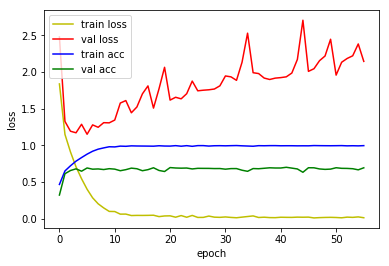

4815/4815 [==============================] - 5s 1ms/sample - loss: 1.2857 - acc: 0.6509
Loss: 1.2857191973386153 Accuracy: 0.65088266

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8367 - acc: 0.4450
Epoch 00001: val_loss improved from inf to 2.25886, saving model to model/checkpoint/1D_CNN_6_conv_custom_conv_3_BN_checkpoint/001-2.2589.hdf5
36805/36805 [==============================] - 107s 3ms/sample - loss: 1.8367 - acc: 0.4450 - val_loss: 2.2589 - val_acc: 0.3319
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1690 - acc: 0.6409
Epoch 00002: val_loss improved from 2.25886 to 1.20072, saving model to model/checkpoint/1D_CNN_6_conv_custom_conv_3_BN_checkpoint/002-1.2007.hdf5
36805/36805 [==============================] - 82s 2ms/sample - loss: 1.1690 - acc: 0.6409 - val_loss: 1.2007 - val_acc: 0.6285
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0317 - acc: 0.9954
Epoch 00028: val_loss did not improve from 0.75476
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.0317 - acc: 0.9954 - val_loss: 1.0278 - val_acc: 0.7803
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0285 - acc: 0.9957
Epoch 00029: val_loss did not improve from 0.75476
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.0285 - acc: 0.9957 - val_loss: 0.9365 - val_acc: 0.8069
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0320 - acc: 0.9945
Epoch 00030: val_loss did not improve from 0.75476
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.0320 - acc: 0.9945 - val_loss: 0.9829 - val_acc: 0.7976
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0273 - acc: 0.9956
Epoch 00031: val_loss did not improve from 0.75476
36805/36805 [===========


1D_CNN_6_conv_custom_conv_3_BN Model


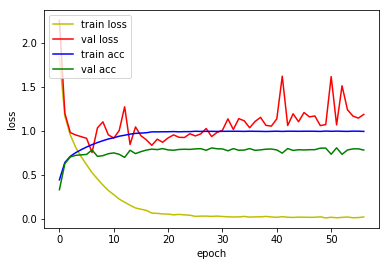

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.8617 - acc: 0.7431
Loss: 0.8617106392376148 Accuracy: 0.7430945

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8330 - acc: 0.4460
Epoch 00001: val_loss improved from inf to 2.34601, saving model to model/checkpoint/1D_CNN_7_conv_custom_conv_3_BN_checkpoint/001-2.3460.hdf5
36805/36805 [==============================] - 114s 3ms/sample - loss: 1.8329 - acc: 0.4461 - val_loss: 2.3460 - val_acc: 0.2819
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1146 - acc: 0.6638
Epoch 00002: val_loss improved from 2.34601 to 1.04324, saving model to model/checkpoint/1D_CNN_7_conv_custom_conv_3_BN_checkpoint/002-1.0432.hdf5
36805/36805 [==============================] - 83s 2ms/sample - loss: 1.1147 - acc: 0.6638 - val_loss: 1.0432 - val_acc: 0.6741
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0093 - acc: 0.9989
Epoch 00056: val_loss did not improve from 0.44382
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.0093 - acc: 0.9989 - val_loss: 0.4722 - val_acc: 0.9005
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0094 - acc: 0.9987
Epoch 00057: val_loss did not improve from 0.44382
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.0094 - acc: 0.9988 - val_loss: 0.5385 - val_acc: 0.8898
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0104 - acc: 0.9983
Epoch 00058: val_loss did not improve from 0.44382
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.0104 - acc: 0.9983 - val_loss: 0.5484 - val_acc: 0.8824
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0197 - acc: 0.9957
Epoch 00059: val_loss did not improve from 0.44382
36805/36805 [===========

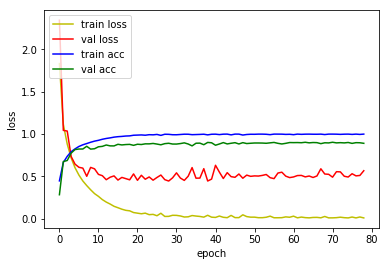

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.5397 - acc: 0.8619
Loss: 0.5396962607018302 Accuracy: 0.8618899

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8278 - acc: 0.4512
Epoch 00001: val_loss improved from inf to 1.90954, saving model to model/checkpoint/1D_CNN_8_conv_custom_conv_3_BN_checkpoint/001-1.9095.hdf5
36805/36805 [==============================] - 120s 3ms/sample - loss: 1.8278 - acc: 0.4513 - val_loss: 1.9095 - val_acc: 0.3783
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9784 - acc: 0.7076
Epoch 00002: val_loss improved from 1.90954 to 0.80878, saving model to model/checkpoint/1D_CNN_8_conv_custom_conv_3_BN_checkpoint/002-0.8088.hdf5
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.9784 - acc: 0.7076 - val_loss: 0.8088 - val_acc: 0.7638
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0301 - acc: 0.9933
Epoch 00026: val_loss did not improve from 0.26685
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.0301 - acc: 0.9933 - val_loss: 0.2899 - val_acc: 0.9229
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0188 - acc: 0.9976
Epoch 00027: val_loss did not improve from 0.26685
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0189 - acc: 0.9976 - val_loss: 0.3149 - val_acc: 0.9215
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0376 - acc: 0.9904
Epoch 00028: val_loss did not improve from 0.26685
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0376 - acc: 0.9904 - val_loss: 0.2801 - val_acc: 0.9273
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0218 - acc: 0.9954
Epoch 00029: val_loss did not improve from 0.26685
36805/36805 [===========

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0074 - acc: 0.9982
Epoch 00085: val_loss did not improve from 0.26590
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.0074 - acc: 0.9982 - val_loss: 0.2884 - val_acc: 0.9380
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0026 - acc: 0.9996
Epoch 00086: val_loss did not improve from 0.26590
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.0027 - acc: 0.9995 - val_loss: 0.2848 - val_acc: 0.9385
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0162 - acc: 0.9954
Epoch 00087: val_loss did not improve from 0.26590
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0162 - acc: 0.9954 - val_loss: 0.2848 - val_acc: 0.9376
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0032 - acc: 0.9993
Epoch 00088: val_loss did not improve from 0.26590
36805/36805 [===========

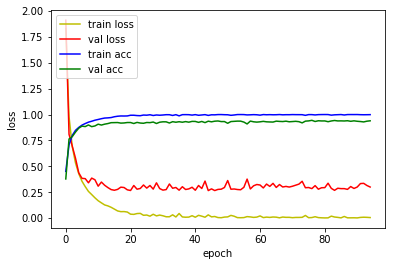

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.3182 - acc: 0.9167
Loss: 0.3182465605368124 Accuracy: 0.9167186

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5358 - acc: 0.5443
Epoch 00001: val_loss improved from inf to 1.77029, saving model to model/checkpoint/1D_CNN_9_conv_custom_conv_3_BN_checkpoint/001-1.7703.hdf5
36805/36805 [==============================] - 134s 4ms/sample - loss: 1.5357 - acc: 0.5443 - val_loss: 1.7703 - val_acc: 0.4263
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6566 - acc: 0.7966
Epoch 00002: val_loss improved from 1.77029 to 0.50202, saving model to model/checkpoint/1D_CNN_9_conv_custom_conv_3_BN_checkpoint/002-0.5020.hdf5
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.6568 - acc: 0.7965 - val_loss: 0.5020 - val_acc: 0.8456
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0063 - acc: 0.9987
Epoch 00056: val_loss did not improve from 0.20522
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0063 - acc: 0.9987 - val_loss: 0.2405 - val_acc: 0.9467
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0074 - acc: 0.9980
Epoch 00057: val_loss did not improve from 0.20522
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0074 - acc: 0.9980 - val_loss: 0.3006 - val_acc: 0.9359
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0126 - acc: 0.9966
Epoch 00058: val_loss did not improve from 0.20522
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0127 - acc: 0.9965 - val_loss: 0.2263 - val_acc: 0.9462
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0156 - acc: 0.9955
Epoch 00059: val_loss did not improve from 0.20522
36805/36805 [===========

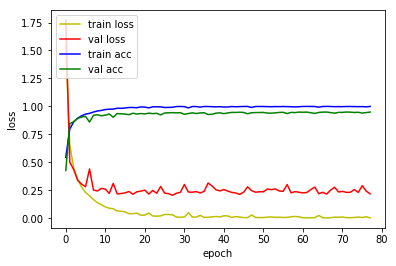

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2791 - acc: 0.9265
Loss: 0.2791371415832456 Accuracy: 0.92647976



In [14]:
for i in range(1, 10):
    model_name = '1D_CNN_{}_conv_custom_conv_3_BN'.format(i)
    model = build_1d_cnn_custom_conv_3_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [15]:
for i in range(1, 10):
    model_name = '1D_CNN_{}_conv_custom_conv_3_BN'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_1_conv_custom_conv_3_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_135 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 64)         256       
_________________________________________________________________
flatten_27 (Flatten)         (None, 1024000)           0         
_________________________________________________________________
dense_27 (Dense)             (None, 16)                16384016  
Total params: 16,384,528
Trainable params: 16,384,400
Non-trainable params: 128
_________________________________________________________________
4815/4815 [==============================] - 4s 798us/sample - loss: 2.4927 - acc: 0.2008
Loss: 2.4927360383644777 Accuracy: 0.20083074

1D_CNN_2_conv_custom_conv_3_BN Model
________________________________________________

4815/4815 [==============================] - 6s 1ms/sample - loss: 1.2857 - acc: 0.6509
Loss: 1.2857191973386153 Accuracy: 0.65088266

1D_CNN_6_conv_custom_conv_3_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_150 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_60 (B (None, 16000, 64)         256       
_________________________________________________________________
conv1d_151 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_61 (B (None, 16000, 64)         256       
_________________________________________________________________
max_pooling1d_118 (MaxPoolin (None, 5333, 64)          0         
_________________________________________________________________
conv1d_152 (Conv1D)          (None, 

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.3182 - acc: 0.9167
Loss: 0.3182465605368124 Accuracy: 0.9167186

1D_CNN_9_conv_custom_conv_3_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_171 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_81 (B (None, 16000, 64)         256       
_________________________________________________________________
conv1d_172 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_82 (B (None, 16000, 64)         256       
_________________________________________________________________
max_pooling1d_136 (MaxPoolin (None, 5333, 64)          0         
_________________________________________________________________
conv1d_173 (Conv1D)          (None, 5

In [16]:
def build_1d_cnn_custom_conv_3_DO_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [17]:
for i in range(1, 10):
    model = build_1d_cnn_custom_conv_3_DO_BN(conv_num=i)
    model.summary()
    del model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_180 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_90 (B (None, 16000, 64)         256       
_________________________________________________________________
flatten_36 (Flatten)         (None, 1024000)           0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 1024000)           0         
_________________________________________________________________
dense_36 (Dense)             (None, 16)                16384016  
Total params: 16,384,528
Trainable params: 16,384,400
Non-trainable params: 128
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_195 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_105 ( (None, 16000, 64)         256       
_________________________________________________________________
conv1d_196 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_106 ( (None, 16000, 64)         256       
_________________________________________________________________
max_pooling1d_154 (MaxPoolin (None, 5333, 64)          0         
_________________________________________________________________
conv1d_197 (Conv1D)          (None, 5333, 64)          12352     
_________________________________________________________________
batch_normalization_v1_107 ( (None, 5333, 64)          256       
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_216 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_126 ( (None, 16000, 64)         256       
_________________________________________________________________
conv1d_217 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_127 ( (None, 16000, 64)         256       
_________________________________________________________________
max_pooling1d_172 (MaxPoolin (None, 5333, 64)          0         
_________________________________________________________________
conv1d_218 (Conv1D)          (None, 5333, 64)          12352     
_________________________________________________________________
batch_normalization_v1_128 ( (None, 5333, 64)          256       
__________

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.2256 - acc: 0.2141
Epoch 00001: val_loss improved from inf to 2.36713, saving model to model/checkpoint/1D_CNN_1_conv_custom_conv_3_DO_BN_checkpoint/001-2.3671.hdf5
36805/36805 [==============================] - 69s 2ms/sample - loss: 3.2259 - acc: 0.2141 - val_loss: 2.3671 - val_acc: 0.2593
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5922 - acc: 0.5188
Epoch 00002: val_loss did not improve from 2.36713
36805/36805 [==============================] - 43s 1ms/sample - loss: 1.5922 - acc: 0.5188 - val_loss: 2.4849 - val_acc: 0.2760
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1051 - acc: 0.6774
Epoch 00003: val_loss did not improve from 2.36713
36805/36805 [==============================] - 43s 1ms/sample - loss: 1.1051 - acc: 0.6774 - val_loss: 2.6675 - val_acc: 0.2835
Epoch 4/500
36800/36805 [======

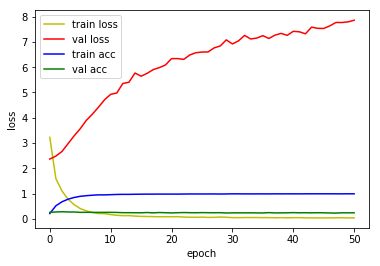

4815/4815 [==============================] - 5s 1ms/sample - loss: 2.3711 - acc: 0.2440
Loss: 2.3711133068100563 Accuracy: 0.24402907

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.9074 - acc: 0.2837
Epoch 00001: val_loss improved from inf to 8.02307, saving model to model/checkpoint/1D_CNN_2_conv_custom_conv_3_DO_BN_checkpoint/001-8.0231.hdf5
36805/36805 [==============================] - 100s 3ms/sample - loss: 4.9074 - acc: 0.2838 - val_loss: 8.0231 - val_acc: 0.1861
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6058 - acc: 0.5370
Epoch 00002: val_loss improved from 8.02307 to 4.23009, saving model to model/checkpoint/1D_CNN_2_conv_custom_conv_3_DO_BN_checkpoint/002-4.2301.hdf5
36805/36805 [==============================] - 68s 2ms/sample - loss: 2.6057 - acc: 0.5370 - val_loss: 4.2301 - val_acc: 0.3541
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2205 - acc: 0.9679
Epoch 00029: val_loss did not improve from 3.74339
36805/36805 [==============================] - 68s 2ms/sample - loss: 0.2205 - acc: 0.9679 - val_loss: 6.1263 - val_acc: 0.3946
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2196 - acc: 0.9689
Epoch 00030: val_loss did not improve from 3.74339
36805/36805 [==============================] - 68s 2ms/sample - loss: 0.2196 - acc: 0.9689 - val_loss: 5.6257 - val_acc: 0.4230
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2089 - acc: 0.9712
Epoch 00031: val_loss did not improve from 3.74339
36805/36805 [==============================] - 68s 2ms/sample - loss: 0.2089 - acc: 0.9712 - val_loss: 6.3790 - val_acc: 0.4114
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2138 - acc: 0.9698
Epoch 00032: val_loss did not improve from 3.74339
36805/36805 [===========

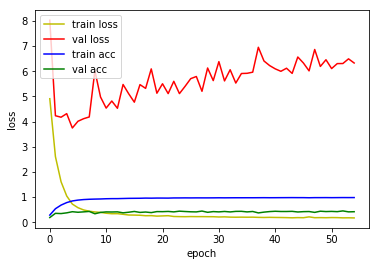

4815/4815 [==============================] - 6s 1ms/sample - loss: 3.9830 - acc: 0.3734
Loss: 3.9829859213665637 Accuracy: 0.3734164

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.3926 - acc: 0.3252
Epoch 00001: val_loss improved from inf to 5.78991, saving model to model/checkpoint/1D_CNN_3_conv_custom_conv_3_DO_BN_checkpoint/001-5.7899.hdf5
36805/36805 [==============================] - 113s 3ms/sample - loss: 3.3925 - acc: 0.3252 - val_loss: 5.7899 - val_acc: 0.1530
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0672 - acc: 0.5244
Epoch 00002: val_loss improved from 5.78991 to 2.50884, saving model to model/checkpoint/1D_CNN_3_conv_custom_conv_3_DO_BN_checkpoint/002-2.5088.hdf5
36805/36805 [==============================] - 77s 2ms/sample - loss: 2.0671 - acc: 0.5244 - val_loss: 2.5088 - val_acc: 0.4435
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - los

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2113 - acc: 0.9568
Epoch 00029: val_loss did not improve from 2.28746
36805/36805 [==============================] - 76s 2ms/sample - loss: 0.2114 - acc: 0.9568 - val_loss: 3.8959 - val_acc: 0.5418
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2226 - acc: 0.9547
Epoch 00030: val_loss did not improve from 2.28746
36805/36805 [==============================] - 76s 2ms/sample - loss: 0.2226 - acc: 0.9547 - val_loss: 3.8139 - val_acc: 0.5560
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1980 - acc: 0.9601
Epoch 00031: val_loss did not improve from 2.28746
36805/36805 [==============================] - 76s 2ms/sample - loss: 0.1979 - acc: 0.9601 - val_loss: 3.8931 - val_acc: 0.5455
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2098 - acc: 0.9578
Epoch 00032: val_loss did not improve from 2.28746
36805/36805 [===========

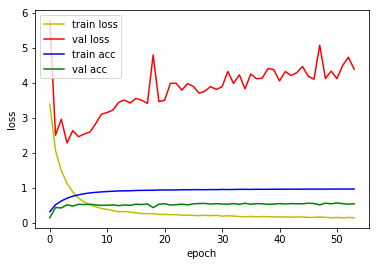

4815/4815 [==============================] - 7s 1ms/sample - loss: 2.4641 - acc: 0.4744
Loss: 2.464087053201899 Accuracy: 0.474351

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7811 - acc: 0.3546
Epoch 00001: val_loss improved from inf to 4.78796, saving model to model/checkpoint/1D_CNN_4_conv_custom_conv_3_DO_BN_checkpoint/001-4.7880.hdf5
36805/36805 [==============================] - 125s 3ms/sample - loss: 2.7812 - acc: 0.3546 - val_loss: 4.7880 - val_acc: 0.2381
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8378 - acc: 0.5171
Epoch 00002: val_loss improved from 4.78796 to 1.41686, saving model to model/checkpoint/1D_CNN_4_conv_custom_conv_3_DO_BN_checkpoint/002-1.4169.hdf5
36805/36805 [==============================] - 79s 2ms/sample - loss: 1.8377 - acc: 0.5171 - val_loss: 1.4169 - val_acc: 0.6119
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss:

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1972 - acc: 0.9407
Epoch 00029: val_loss did not improve from 1.28013
36805/36805 [==============================] - 79s 2ms/sample - loss: 0.1973 - acc: 0.9406 - val_loss: 1.9529 - val_acc: 0.6713
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1829 - acc: 0.9456
Epoch 00030: val_loss did not improve from 1.28013
36805/36805 [==============================] - 79s 2ms/sample - loss: 0.1829 - acc: 0.9456 - val_loss: 1.7355 - val_acc: 0.6902
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1720 - acc: 0.9483
Epoch 00031: val_loss did not improve from 1.28013
36805/36805 [==============================] - 79s 2ms/sample - loss: 0.1720 - acc: 0.9483 - val_loss: 2.1257 - val_acc: 0.6452
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1678 - acc: 0.9502
Epoch 00032: val_loss did not improve from 1.28013
36805/36805 [===========

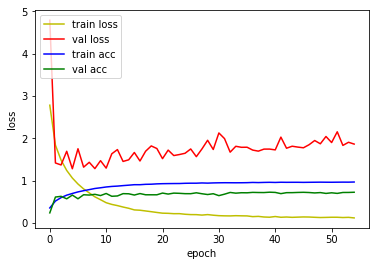

4815/4815 [==============================] - 7s 1ms/sample - loss: 1.4711 - acc: 0.6108
Loss: 1.471127874259513 Accuracy: 0.6107996

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7610 - acc: 0.3460
Epoch 00001: val_loss improved from inf to 2.94604, saving model to model/checkpoint/1D_CNN_5_conv_custom_conv_3_DO_BN_checkpoint/001-2.9460.hdf5
36805/36805 [==============================] - 134s 4ms/sample - loss: 2.7609 - acc: 0.3460 - val_loss: 2.9460 - val_acc: 0.3010
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7491 - acc: 0.5279
Epoch 00002: val_loss improved from 2.94604 to 1.30380, saving model to model/checkpoint/1D_CNN_5_conv_custom_conv_3_DO_BN_checkpoint/002-1.3038.hdf5
36805/36805 [==============================] - 82s 2ms/sample - loss: 1.7490 - acc: 0.5279 - val_loss: 1.3038 - val_acc: 0.6424
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2023 - acc: 0.9368
Epoch 00028: val_loss did not improve from 0.97117
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.2023 - acc: 0.9368 - val_loss: 1.2140 - val_acc: 0.7503
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1835 - acc: 0.9425
Epoch 00029: val_loss did not improve from 0.97117
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.1834 - acc: 0.9425 - val_loss: 1.6709 - val_acc: 0.7081
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1863 - acc: 0.9411
Epoch 00030: val_loss did not improve from 0.97117
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.1863 - acc: 0.9411 - val_loss: 1.5029 - val_acc: 0.7242
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1734 - acc: 0.9451
Epoch 00031: val_loss did not improve from 0.97117
36805/36805 [===========

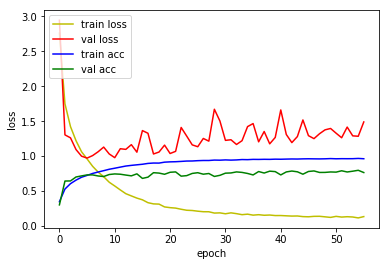

4815/4815 [==============================] - 7s 1ms/sample - loss: 1.0920 - acc: 0.6847
Loss: 1.0920000130266168 Accuracy: 0.6847352

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7073 - acc: 0.3082
Epoch 00001: val_loss improved from inf to 2.04673, saving model to model/checkpoint/1D_CNN_6_conv_custom_conv_3_DO_BN_checkpoint/001-2.0467.hdf5
36805/36805 [==============================] - 143s 4ms/sample - loss: 2.7074 - acc: 0.3082 - val_loss: 2.0467 - val_acc: 0.3573
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7528 - acc: 0.4976
Epoch 00002: val_loss improved from 2.04673 to 1.30948, saving model to model/checkpoint/1D_CNN_6_conv_custom_conv_3_DO_BN_checkpoint/002-1.3095.hdf5
36805/36805 [==============================] - 83s 2ms/sample - loss: 1.7528 - acc: 0.4977 - val_loss: 1.3095 - val_acc: 0.6010
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - los

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2746 - acc: 0.9131
Epoch 00026: val_loss did not improve from 0.56187
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.2747 - acc: 0.9131 - val_loss: 0.6560 - val_acc: 0.8318
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2625 - acc: 0.9140
Epoch 00027: val_loss did not improve from 0.56187
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.2626 - acc: 0.9140 - val_loss: 0.5820 - val_acc: 0.8565
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2479 - acc: 0.9189
Epoch 00028: val_loss did not improve from 0.56187
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.2480 - acc: 0.9189 - val_loss: 0.6188 - val_acc: 0.8446
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2391 - acc: 0.9228
Epoch 00029: val_loss did not improve from 0.56187
36805/36805 [===========

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0895 - acc: 0.9704
Epoch 00085: val_loss did not improve from 0.53639
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.0895 - acc: 0.9704 - val_loss: 0.6670 - val_acc: 0.8786
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0828 - acc: 0.9742
Epoch 00086: val_loss did not improve from 0.53639
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.0828 - acc: 0.9742 - val_loss: 0.6633 - val_acc: 0.8828
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0803 - acc: 0.9746
Epoch 00087: val_loss did not improve from 0.53639
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.0805 - acc: 0.9746 - val_loss: 0.6737 - val_acc: 0.8786
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0910 - acc: 0.9710
Epoch 00088: val_loss did not improve from 0.53639
36805/36805 [===========

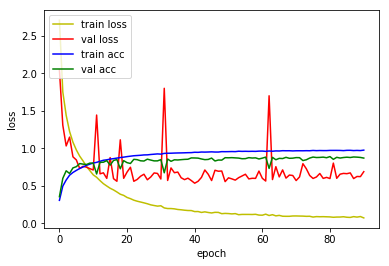

4815/4815 [==============================] - 7s 2ms/sample - loss: 0.6773 - acc: 0.8343
Loss: 0.6772818665019201 Accuracy: 0.8342679

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.9535 - acc: 0.2605
Epoch 00001: val_loss improved from inf to 2.14748, saving model to model/checkpoint/1D_CNN_7_conv_custom_conv_3_DO_BN_checkpoint/001-2.1475.hdf5
36805/36805 [==============================] - 153s 4ms/sample - loss: 2.9533 - acc: 0.2606 - val_loss: 2.1475 - val_acc: 0.3566
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8217 - acc: 0.4714
Epoch 00002: val_loss improved from 2.14748 to 1.20726, saving model to model/checkpoint/1D_CNN_7_conv_custom_conv_3_DO_BN_checkpoint/002-1.2073.hdf5
36805/36805 [==============================] - 84s 2ms/sample - loss: 1.8217 - acc: 0.4713 - val_loss: 1.2073 - val_acc: 0.6406
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - los

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2492 - acc: 0.9217
Epoch 00024: val_loss improved from 0.34267 to 0.33921, saving model to model/checkpoint/1D_CNN_7_conv_custom_conv_3_DO_BN_checkpoint/024-0.3392.hdf5
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.2493 - acc: 0.9217 - val_loss: 0.3392 - val_acc: 0.9108
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2415 - acc: 0.9230
Epoch 00025: val_loss did not improve from 0.33921
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.2415 - acc: 0.9230 - val_loss: 0.3428 - val_acc: 0.9136
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2265 - acc: 0.9284
Epoch 00026: val_loss did not improve from 0.33921
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.2265 - acc: 0.9284 - val_loss: 0.3424 - val_acc: 0.9015
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - los

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0991 - acc: 0.9690
Epoch 00052: val_loss did not improve from 0.29754
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.0991 - acc: 0.9690 - val_loss: 0.5192 - val_acc: 0.8810
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0993 - acc: 0.9668
Epoch 00053: val_loss did not improve from 0.29754
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.0993 - acc: 0.9667 - val_loss: 0.3968 - val_acc: 0.9113
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0987 - acc: 0.9673
Epoch 00054: val_loss did not improve from 0.29754
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.0987 - acc: 0.9673 - val_loss: 0.2992 - val_acc: 0.9257
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0901 - acc: 0.9701
Epoch 00055: val_loss did not improve from 0.29754
36805/36805 [===========

Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0424 - acc: 0.9857
Epoch 00111: val_loss did not improve from 0.29670
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.0424 - acc: 0.9857 - val_loss: 0.5011 - val_acc: 0.9010
Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0441 - acc: 0.9854
Epoch 00112: val_loss did not improve from 0.29670
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.0441 - acc: 0.9854 - val_loss: 0.4031 - val_acc: 0.9250
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0456 - acc: 0.9854
Epoch 00113: val_loss did not improve from 0.29670
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.0456 - acc: 0.9854 - val_loss: 0.4610 - val_acc: 0.9154
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0530 - acc: 0.9826
Epoch 00114: val_loss did not improve from 0.29670
36805/36805 [=======

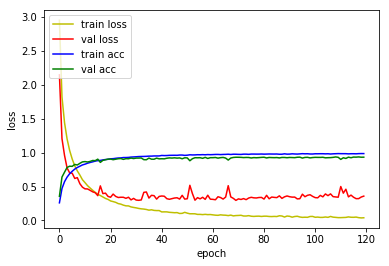

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.3412 - acc: 0.9161
Loss: 0.341155754080814 Accuracy: 0.91609555

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.9889 - acc: 0.2533
Epoch 00001: val_loss improved from inf to 2.45246, saving model to model/checkpoint/1D_CNN_8_conv_custom_conv_3_DO_BN_checkpoint/001-2.4525.hdf5
36805/36805 [==============================] - 166s 5ms/sample - loss: 2.9887 - acc: 0.2533 - val_loss: 2.4525 - val_acc: 0.2108
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7975 - acc: 0.4683
Epoch 00002: val_loss improved from 2.45246 to 1.02209, saving model to model/checkpoint/1D_CNN_8_conv_custom_conv_3_DO_BN_checkpoint/002-1.0221.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 1.7975 - acc: 0.4683 - val_loss: 1.0221 - val_acc: 0.6902
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - los

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1741 - acc: 0.9446
Epoch 00025: val_loss did not improve from 0.22640
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.1743 - acc: 0.9445 - val_loss: 0.2399 - val_acc: 0.9352
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1741 - acc: 0.9442
Epoch 00026: val_loss improved from 0.22640 to 0.20619, saving model to model/checkpoint/1D_CNN_8_conv_custom_conv_3_DO_BN_checkpoint/026-0.2062.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.1741 - acc: 0.9441 - val_loss: 0.2062 - val_acc: 0.9413
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1610 - acc: 0.9479
Epoch 00027: val_loss did not improve from 0.20619
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.1610 - acc: 0.9478 - val_loss: 0.2316 - val_acc: 0.9369
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - los

In [ ]:
for i in range(1, 10):
    model_name = '1D_CNN_{}_conv_custom_conv_3_DO_BN'.format(i)
    model = build_1d_cnn_custom_conv_3_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [ ]:
for i in range(1, 10):
    model_name = '1D_CNN_{}_conv_custom_conv_3_DO_BN'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)